# Validator Profitability & Stake Inequality Across Protocol Regimes

This notebook accompanies a public article exploring how Solana’s validator economics shift under several proposed (or discussed) regimes.
We keep the original analysis code **unchanged** and simply provide cleaner structure and a final **summary chart** for the inequality results (Gini coefficients) using **Pygal**.

**Regimes compared**
- **Status Quo** (baseline)
- **No Vote Fees**
- **80% Vote Fees**
- **80% Vote Fees + SIMD‑228**
- **0.135 Vote Fees + SIMD‑228**

**What to expect**
1. The original analysis cells (as‑is, unchanged).
2. A final summary section that renders a Pygal bar chart of Gini coefficients across the five regimes.


## Contents
- [Context & Goals](#context--goals)
- [Original Analysis (Unchanged)](#original-analysis-unchanged)
- [Summary: Gini Coefficients (Pygal)](#summary-gini-coefficients-pygal)


## Context & Goals
We are interested in how vote fees, block rewards, and inflation mechanisms affect validator profitability and inequality.
The **Gini coefficient** summarizes inequality (0 = perfect equality, 1 = maximal inequality). We compute Gini on per‑validator profit for each regime.
We do **not** modify your original code or variable names—only add structure and a Pygal summary at the end.


## Original Analysis (Unchanged)
> The following cells are exactly as in your working notebook. We have **not** altered code cells—only reorganized the notebook around them.




We analyze the effects of Alpenglow and SIMD-228 on validator profitability and distribution. We use Helius' dataset on all Solana Validators in data/validator_profit.csv. To begin, we'll look at the dataset and analyze the status quo with no Alpenglow or SIMD-228.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pygal


from IPython.display import SVG, display
import sys

sys.path.append('../')

from scripts.utils import *
s_quo = pd.read_csv('../data/validator_profit.csv')
s_quo.head()


Rank     Validator Name                        Validator Vote Account  \
0     1             Helius   he1iusunGwqrNtafDtLdhsUQDFvo13z9sUa36PauBtk   
1     2    Binance Staking  3N7s9zXMZ4QqvHQR15t5GNHyqc89KduzMP7423eWiD5g   
2     3        Coinbase 02  6D2jqw9hyVCpppZexquxa74Fn33rJzzBx38T58VucHx9   
3     4             Galaxy  CvSb7wdQAFpHuSpTYTJnX5SYH4hCfQ9VuGnqrKaKwycB   
4     5  Ledger by Figment  26pV97Ce83ZQ6Kz9XT4td8tdoUFPTng8Fb8gPyc53dJx   

   Active Stake (SOL)  Percentage of total stake (%)  Cumulative Stake (%)  \
0         13356080.98                        0.03554                 0.036   
1         11506125.17                        0.03062                 0.066   
2         10022736.57                        0.02667                 0.093   
3          8975929.50                        0.02389                 0.117   
4          8567673.97                        0.02280                 0.140   

   Issuance Rewards Commission (%)  Jito MEV Commission Rate (%)  \
0                             0.00                          0.00   
1                             0.08                          0.10   
2                             0.08                          0.08   
3                             0.05                          0.25   
4                             0.07                          0.07   

   Issuance Revenue (SOL)  Issuance Revenue as % of Total Revenue (%)  \
0                    0.00                                      0.0000   
1                63261.34                                      0.2758   
2                55105.59                                      0.2796   
3                30843.86                                      0.1724   
4                41217.37                                      0.2554   

   Jito MEV Revenue (SOL)  Jito MEV Revenue as % of Total Revenue (%)  \
0                    0.00                                      0.0000   
1                15821.10                                      0.0690   
2                11025.13                                      0.0559   
3                30855.10                                      0.1724   
4                 8246.48                                      0.0511   

   Block Rewards Revenue (SOL)  \
0                    174465.76   
1                    150300.44   
2                    130923.46   
3                    117249.39   
4                    111916.49   

   Block Rewards Revenue as % of Total Revenue (%)  Total Revenue (SOL)  \
0                                           1.0000            174465.76   
1                                           0.6552            229382.88   
2                                           0.6644            197054.18   
3                                           0.6552            178948.35   
4                                           0.6935            161380.34   

   Server Cost (SOL)  Voting Cost (SOL)  Profit(SOL) Profitable  
0             133.33                365    173967.42        YES  
1             133.33                365    228884.55        YES  
2             133.33                365    196555.85        YES  
3             133.33                365    178450.02        YES  
4             133.33                365    160882.01        YES

percent of total stake in each bucket:
<1k: 0.0%
1k-10k: 0.07%
10k-50k: 4.03%
50k-100k: 3.71%
100k-250k: 11.44%
250k-500k: 5.86%
500k-1m: 6.0%
>1m: 68.9%


/var/folders/g8/htn76nmn625fn9k4_20hws7c0000gn/T/ipykernel_37574/2572616546.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stake_per_bucket = s_quo.groupby(stake_binned)['Active Stake (SOL)'].sum().reindex(bin_labels, fill_value=0)


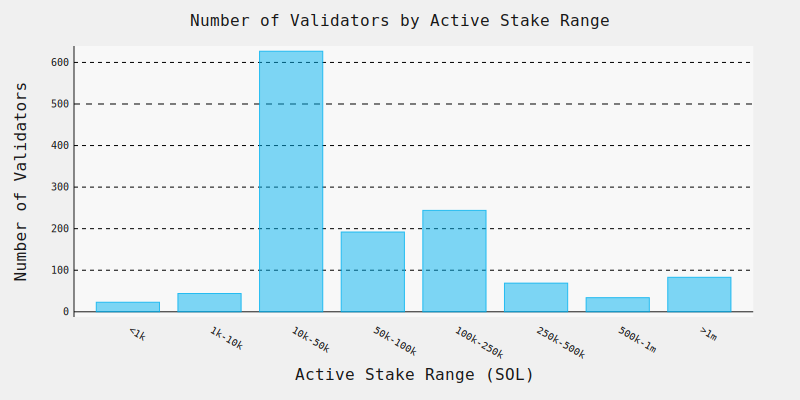

In [25]:
# bin the active stake into specified ranges for a bar chart
stake_bins = [0, 1000, 10_000, 50_000, 100_000, 250_000, 500_000, 1_000_000, s_quo['Active Stake (SOL)'].max() + 1]
bin_labels = [
    '<1k', '1k-10k', '10k-50k', '50k-100k', '100k-250k',
    '250k-500k', '500k-1m', '>1m'
]
stake_binned = pd.cut(
    s_quo['Active Stake (SOL)'],
    bins=stake_bins,
    labels=bin_labels,
    right=False,
    include_lowest=True
)
validator_counts = stake_binned.value_counts().sort_index()

# calculate percent of total stake in each bucket
total_stake = s_quo['Active Stake (SOL)'].sum()
stake_per_bucket = s_quo.groupby(stake_binned)['Active Stake (SOL)'].sum().reindex(bin_labels, fill_value=0)
percent_per_bucket = (stake_per_bucket / total_stake * 100).round(2)

# print percent of total stake in each bucket
print('percent of total stake in each bucket:')
for label in bin_labels:
    print(f'{label}: {percent_per_bucket[label]}%')

# plot the number of validators in each stake range using pygal
chart = pygal.Bar(
    title='Number of Validators by Active Stake Range',
    x_title='Active Stake Range (SOL)',
    y_title='Number of Validators',
    style=pygal.style.BlueStyle,
    width=800,
    height=400,
    x_label_rotation=30,
    show_legend=False,
    human_readable=True,
)

chart.x_labels = bin_labels
chart.add('validators', [int(validator_counts.get(label, 0)) for label in bin_labels])

display(SVG(chart.render()))


Percent of total stake in each bucket:
<1k: 0.0%
1k-10k: 0.07%
10k-50k: 4.03%
50k-100k: 3.71%
100k-250k: 11.44%
250k-500k: 5.86%
500k-1m: 6.0%
>1m: 68.9%


/var/folders/g8/htn76nmn625fn9k4_20hws7c0000gn/T/ipykernel_37574/293680659.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stake_per_bucket = s_quo.groupby(stake_binned)['Active Stake (SOL)'].sum().reindex(bin_labels, fill_value=0)


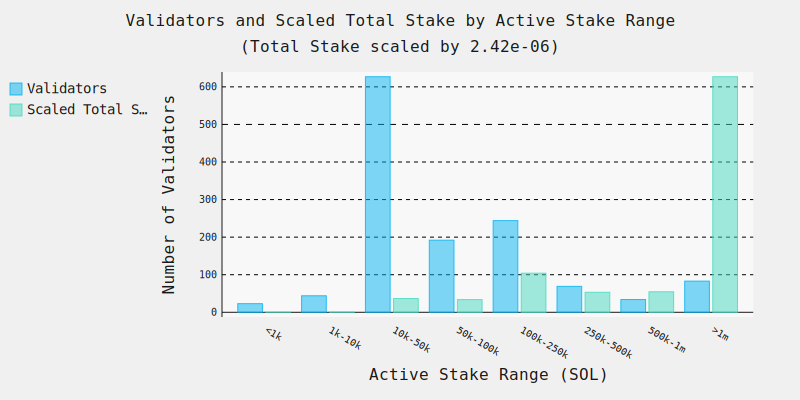

In [30]:
import pygal
from IPython.display import SVG
import pandas as pd

# bin the active stake into specified ranges
stake_bins = [0, 1000, 10_000, 50_000, 100_000, 250_000, 500_000, 1_000_000, s_quo['Active Stake (SOL)'].max() + 1]
bin_labels = [
    '<1k', '1k-10k', '10k-50k', '50k-100k', '100k-250k',
    '250k-500k', '500k-1m', '>1m'
]
stake_binned = pd.cut(
    s_quo['Active Stake (SOL)'],
    bins=stake_bins,
    labels=bin_labels,
    right=False,
    include_lowest=True
)
validator_counts = stake_binned.value_counts().sort_index()

# calculate total stake in each bucket
total_stake = s_quo['Active Stake (SOL)'].sum()
stake_per_bucket = s_quo.groupby(stake_binned)['Active Stake (SOL)'].sum().reindex(bin_labels, fill_value=0)
percent_per_bucket = (stake_per_bucket / total_stake * 100).round(2)

# print percent of total stake in each bucket
print('Percent of total stake in each bucket:')
for label in bin_labels:
    print(f'{label}: {percent_per_bucket[label]}%')

# scale total stake to fit the same y-axis as validator counts
max_validators = max([int(validator_counts.get(label, 0)) for label in bin_labels])
max_stake = max([float(stake_per_bucket[label]) for label in bin_labels])
scale_factor = max_validators / max_stake if max_stake > 0 else 1
scaled_stake = [float(stake_per_bucket[label]) * scale_factor for label in bin_labels]

# create a bar chart with an overlaid line using pygal
chart = pygal.Bar(
    title=f'Validators and Scaled Total Stake by Active Stake Range\n(Total Stake scaled by {scale_factor:.2e})',
    x_title='Active Stake Range (SOL)',
    y_title='Number of Validators',
    style=pygal.style.BlueStyle,
    width=800,
    height=400,
    x_label_rotation=30,
    show_legend=True,
    human_readable=True,
)

chart.x_labels = bin_labels
chart.add('Validators', [int(validator_counts.get(label, 0)) for label in bin_labels])
chart.add(f'Scaled Total Stake (SOL, x{scale_factor:.2e})', scaled_stake, stroke=True, fill=False, show_dots=True, dots_size=3)

display(SVG(chart.render()))

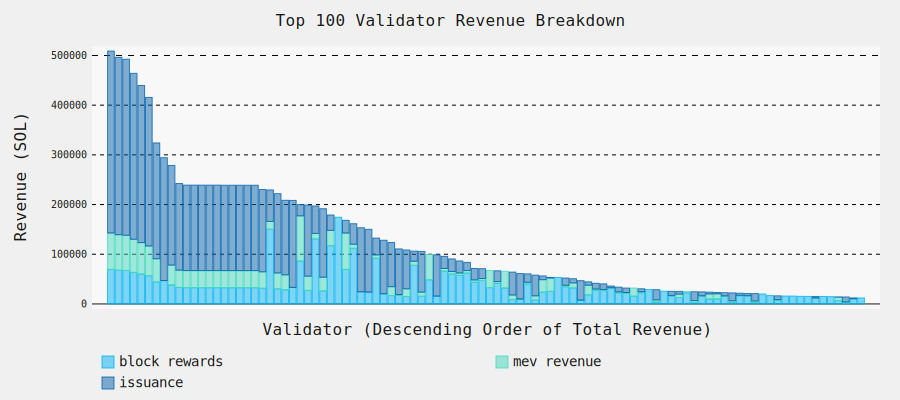

In [20]:

# calculate block rewards revenue
block_rewards = s_quo['Total Revenue (SOL)'] * s_quo['Block Rewards Revenue as % of Total Revenue (%)']

issuance = s_quo['Issuance Revenue (SOL)'].astype(float)

# mev revenue = total revenue - block rewards - issuance
mev_revenue = s_quo['Jito MEV Revenue (SOL)'].astype(float)


top_n = 100
s_quo_sorted = s_quo.sort_values('Total Revenue (SOL)', ascending=False).head(top_n)
block_rewards_top = block_rewards.loc[s_quo_sorted.index]
mev_revenue_top = mev_revenue.loc[s_quo_sorted.index]
issuance_top = issuance.loc[s_quo_sorted.index]
validator_names = s_quo_sorted['Validator Name'].astype(str)

chart = pygal.StackedBar(
    title='Top 100 Validator Revenue Breakdown',
    x_title='Validator (Descending Order of Total Revenue)',
    y_title='Revenue (SOL)',
    style=pygal.style.BlueStyle,
    width=900,
    height=400,
    x_label_rotation=30,
    show_legend=True,
    human_readable=True,
    legend_at_bottom=True,
    
    print_values=False,
)

# chart.x_labels = validator_names

chart.add('block rewards', [round(v, 2) for v in block_rewards_top])
chart.add('mev revenue', [round(v, 2) for v in mev_revenue_top])
if issuance_top.sum() > 0:
    chart.add('issuance', [round(v, 2) for v in issuance_top])

display(SVG(chart.render()))
# chart.render_to_file('validator_total_revenue_breakdown.svg')


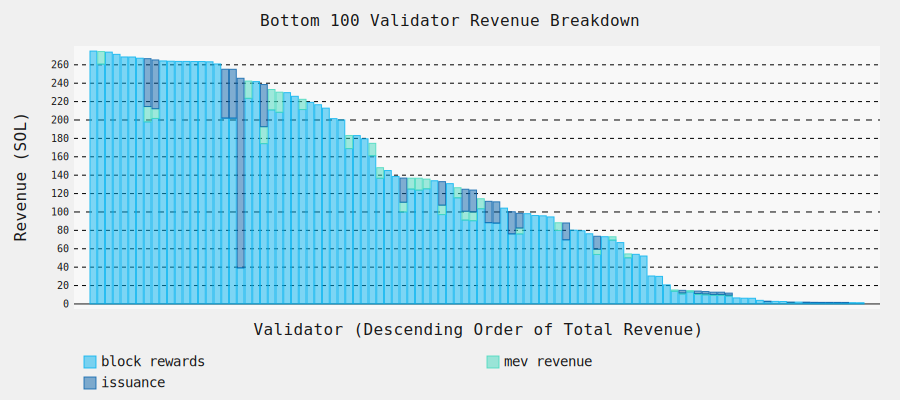

In [21]:
import pygal
from IPython.display import SVG, display

# select bottom 100 validators by total revenue, show in descending order
bottom_n = 100
s_quo_sorted_bottom = s_quo.sort_values('Total Revenue (SOL)', ascending=True).head(bottom_n)
s_quo_sorted_bottom = s_quo_sorted_bottom.sort_values('Total Revenue (SOL)', ascending=False)
block_rewards_bottom = s_quo_sorted_bottom['Total Revenue (SOL)'] * s_quo_sorted_bottom['Block Rewards Revenue as % of Total Revenue (%)']
mev_revenue_bottom = s_quo_sorted_bottom['Jito MEV Revenue (SOL)'].astype(float)
if 'Issuance Revenue (SOL)' in s_quo_sorted_bottom.columns:
    issuance_bottom = s_quo_sorted_bottom['Issuance Revenue (SOL)'].astype(float)
else:
    issuance_bottom = None
validator_names_bottom = s_quo_sorted_bottom['Validator Name'].astype(str)

chart_bottom = pygal.StackedBar(
    title='Bottom 100 Validator Revenue Breakdown',
    x_title='Validator (Descending Order of Total Revenue)',
    y_title='Revenue (SOL)',
    style=pygal.style.BlueStyle,
    width=900,
    height=400,
    x_label_rotation=30,
    show_legend=True,
    human_readable=True,
    legend_at_bottom=True,
    print_values=False,
)

chart_bottom.add('block rewards', [round(v, 2) for v in block_rewards_bottom])
chart_bottom.add('mev revenue', [round(v, 2) for v in mev_revenue_bottom])
if issuance_bottom is not None and issuance_bottom.sum() > 0:
    chart_bottom.add('issuance', [round(v, 2) for v in issuance_bottom])

display(SVG(chart_bottom.render()))


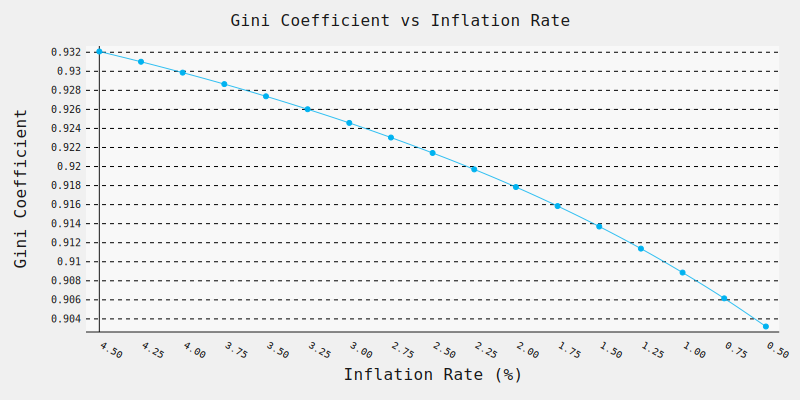

In [ ]:
import pygal
from IPython.display import SVG, display

gini_improvements = calculate_gini_inflation_ratio(s_quo)


# create a line chart to visualize gini coefficient vs inflation rate
line_chart = pygal.Line(
    title='Gini Coefficient vs Inflation Rate',
    x_title='Inflation Rate (%)',
    y_title='Gini Coefficient',
    style=pygal.style.BlueStyle,
    width=800,
    height=400,
    show_legend=False,
    x_label_rotation=30,
    human_readable=True,
    interpolate='cubic'
)

# extract inflation rates and gini coefficients
inflation_rates = [float(imp['inflation_rate']) for imp in gini_improvements]
gini_coefficients = [float(imp['gini_coefficient']) for imp in gini_improvements]

# set x labels as inflation rates formatted to 2 decimals
line_chart.x_labels = [f"{rate:.2f}" for rate in inflation_rates]
line_chart.add('gini coefficient', gini_coefficients)

display(SVG(line_chart.render()))


/Users/mustafaqazi/research/Solana-Validator-Analysis/notebooks/../scripts/utils.py:159: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('stake_bucket')['Profit(SOL)']


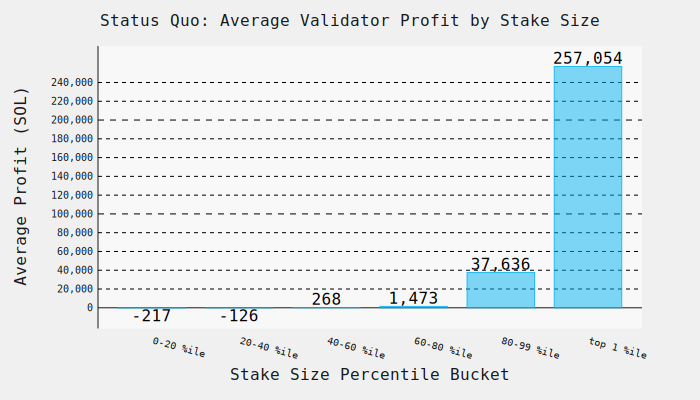

Gini Coefficient: 0.93
Shannon Entropy: 0.64


In [7]:
import numpy as np
import pygal
from IPython.display import SVG, display

# make a local copy to avoid modifying s_quo in place
s_quo_local = s_quo.copy()

chart = profit_distribution_chart(s_quo_local, 'Status Quo: Average Validator Profit by Stake Size')

display(SVG(chart.render()))
# chart.render_to_file('validator_avg_profit_by_stake_bucket.svg')

gini = calc_modified_gini(s_quo_local)
shannon = calc_shannon_entropy(s_quo_local)
print(f"Gini Coefficient: {gini:.2f}")
print(f"Shannon Entropy: {shannon:.2f}")


/Users/mustafaqazi/research/Solana-Validator-Analysis/notebooks/../scripts/utils.py:159: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('stake_bucket')['Profit(SOL)']


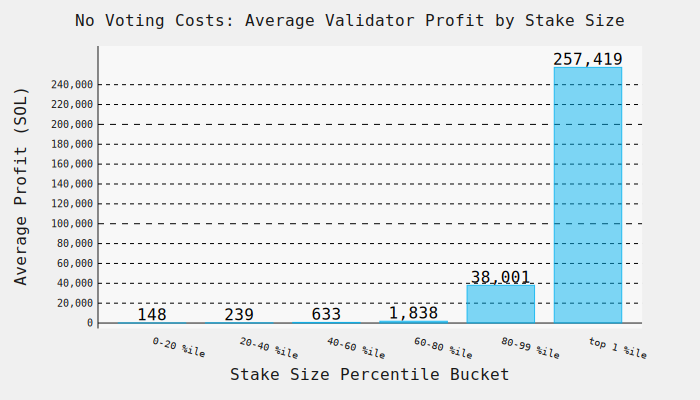

Gini Coefficient: 0.91%
Shannon Entropy: 0.66


In [8]:

from IPython.display import SVG, display

alpenglow_no_vote = s_quo.copy()

# set voting cost to zero and recompute profits
alpenglow_no_vote = change_vote_fees(alpenglow_no_vote, 0)

alpenglow_no_vote = recompute_profits(alpenglow_no_vote)


chart = profit_distribution_chart(alpenglow_no_vote, 'No Voting Costs: Average Validator Profit by Stake Size')

display(SVG(chart.render()))
# chart.render_to_file('validator_avg_profit_by_stake_bucket.svg')

alpenglow_no_vote.head()

gini = calc_modified_gini(alpenglow_no_vote)
shannon = calc_shannon_entropy(alpenglow_no_vote)
print(f"Gini Coefficient: {gini:.2f}%")
print(f"Shannon Entropy: {shannon:.2f}")

/Users/mustafaqazi/research/Solana-Validator-Analysis/notebooks/../scripts/utils.py:159: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('stake_bucket')['Profit(SOL)']


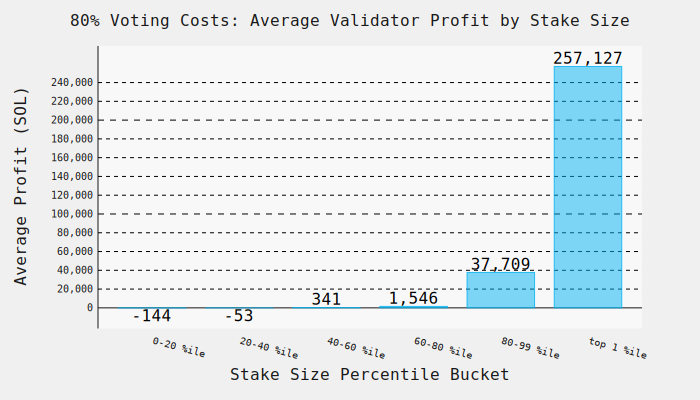

Gini Coefficient: 0.93%
Shannon Entropy: 0.65


In [9]:
import numpy as np
import pygal
from IPython.display import SVG, display

# make a local copy of s_quo to avoid modifying the original
df = s_quo.copy()

df = change_vote_fees(df, 0.8)

df = recompute_profits(df)

chart = profit_distribution_chart(df, '80% Voting Costs: Average Validator Profit by Stake Size')

display(SVG(chart.render()))
# chart.render_to_file('validator_avg_profit_by_stake_bucket.svg')

gini = calc_modified_gini(df)
shannon = calc_shannon_entropy(df)
print(f"Gini Coefficient: {gini:.2f}%")
print(f"Shannon Entropy: {shannon:.2f}")

In [10]:

df = load_and_clean_data('../data/validator_profit.csv')

low_stake = apply_simd228(change_vote_fees(df, 0.135), 0.4, 0.02)
med_stake = apply_simd228(change_vote_fees(df, 0.135), 0.6, 0.02)
high_stake = apply_simd228(change_vote_fees(df, 0.135), 0.85, 0.02)

low_stake = recompute_profits(low_stake)
med_stake = recompute_profits(med_stake)
high_stake = recompute_profits(high_stake)

0.013984224582796538
0.004508066615170332
0.001560911085414225


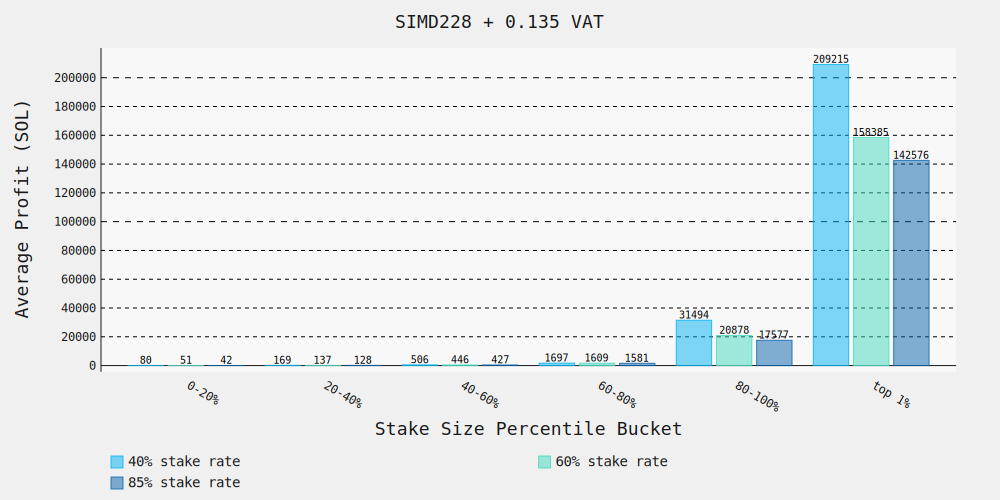

gini coefficient for low stake regime profit: 0.9082
gini coefficient for medium stake regime profit: 0.8884
gini coefficient for high stake regime profit: 0.8793
shannon entropy for low stake regime profit: 0.6738
shannon entropy for medium stake regime profit: 0.7047
shannon entropy for high stake regime profit: 0.7167


In [11]:

def bucket_profits_with_top1(df, num_buckets=5):
    # keep only relevant columns and sort by stake
    df = df[['Active Stake (SOL)', 'Profit(SOL)']].dropna().sort_values('Active Stake (SOL)').reset_index(drop=True)
    n = len(df)
    # determine the cutoff for the top 1 percentile
    top1_cutoff = int(np.ceil(n * 0.99))
    # assign all but the top 1% to quantile buckets, top 1% to a separate bucket
    bucket_labels = [f'{int(i*100/num_buckets)}-{int((i+1)*100/num_buckets)}%' for i in range(num_buckets)] + ['top 1%']
    bucket_assignment = pd.Series([None] * n)
    # assign quantile buckets to the first 99%
    if top1_cutoff > 0:
        bucket_assignment.iloc[:top1_cutoff] = pd.qcut(
            np.arange(top1_cutoff), num_buckets, labels=[f'{int(i*100/num_buckets)}-{int((i+1)*100/num_buckets)}%' for i in range(num_buckets)]
        )
    # assign 'top 1%' to the last 1%
    bucket_assignment.iloc[top1_cutoff:] = 'top 1%'
    df['bucket'] = bucket_assignment

    grouped = df.groupby('bucket', observed=True)['Profit(SOL)']
    avg_profits = grouped.mean().reindex(bucket_labels).tolist()
    total_profits = grouped.sum().reindex(bucket_labels).tolist()
    labels = bucket_labels

    return labels, avg_profits, total_profits

# compute for each scenario
labels, low_avg, low_total = bucket_profits_with_top1(low_stake, num_buckets=5)
_, med_avg, med_total = bucket_profits_with_top1(med_stake, num_buckets=5)
_, high_avg, high_total = bucket_profits_with_top1(high_stake, num_buckets=5)

from pygal.style import Style

# create a custom style with smaller value font size
custom_style = pygal.style.BlueStyle(
    value_font_size=10,
    label_font_size=12,
    major_label_font_size=12,
    legend_font_size=14,
    tooltip_font_size=12,
    title_font_size=18,
)

chart = pygal.Bar(
    title='SIMD228 + 0.135 VAT',
    x_title='Stake Size Percentile Bucket',
    y_title='Average Profit (SOL)',
    width=1000,
    height=500,
    show_legend=True,
    legend_at_bottom=True,
    style=custom_style,
    human_readable=True,
    value_formatter=lambda x: f'{x:.0f}',
    show_y_guides=True,
    print_values=True,
    print_values_position='top',
    x_label_rotation=30,  # rotate x axis labels for readability
)

chart.x_labels = labels
chart.add('40% stake rate', [{'value': avg if avg is not np.nan else 0, 'label': f'{int(tot):,}' if tot is not np.nan else '0'} for avg, tot in zip(low_avg, low_total)])
chart.add('60% stake rate', [{'value': avg if avg is not np.nan else 0, 'label': f'{int(tot):,}' if tot is not np.nan else '0'} for avg, tot in zip(med_avg, med_total)])
chart.add('85% stake rate', [{'value': avg if avg is not np.nan else 0, 'label': f'{int(tot):,}' if tot is not np.nan else '0'} for avg, tot in zip(high_avg, high_total)])

display(SVG(chart.render()))


# calculate and print gini coefficient for each regime's profit
low_gini = calc_modified_gini(low_stake)
med_gini = calc_modified_gini(med_stake)
high_gini = calc_modified_gini(high_stake)

low_shannon = calc_shannon_entropy(low_stake)
med_shannon = calc_shannon_entropy(med_stake)
high_shannon = calc_shannon_entropy(high_stake) 

print('gini coefficient for low stake regime profit:', f'{low_gini:.4f}')
print('gini coefficient for medium stake regime profit:', f'{med_gini:.4f}')
print('gini coefficient for high stake regime profit:', f'{high_gini:.4f}')

print('shannon entropy for low stake regime profit:', f'{low_shannon:.4f}')
print('shannon entropy for medium stake regime profit:', f'{med_shannon:.4f}')
print('shannon entropy for high stake regime profit:', f'{high_shannon:.4f}')



In [12]:

df = load_and_clean_data('../data/validator_profit.csv')

low_stake = apply_simd228(df, 0.4, 0.02)
med_stake = apply_simd228(df, 0.6, 0.02)
high_stake = apply_simd228(df, 0.85, 0.02)

low_stake = recompute_profits(low_stake)
med_stake = recompute_profits(med_stake)
high_stake = recompute_profits(high_stake)


0.013984224582796538
0.004508066615170332
0.001560911085414225


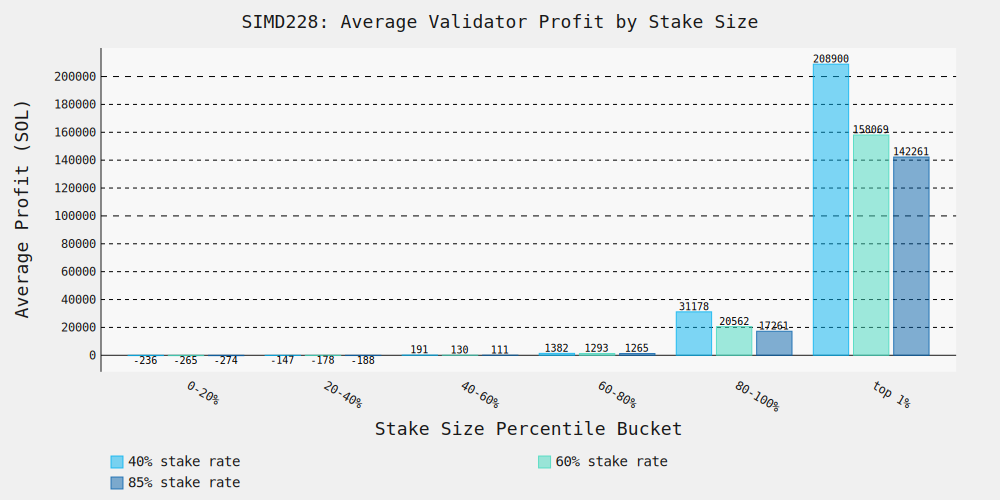

gini coefficient for low stake regime profit: 0.9248
gini coefficient for medium stake regime profit: 0.9086
gini coefficient for high stake regime profit: 0.9012
shannon entropy for low stake regime profit: 0.6556
shannon entropy for medium stake regime profit: 0.6827
shannon entropy for high stake regime profit: 0.6930


In [13]:

def bucket_profits_with_top1(df, num_buckets=5):
    # keep only relevant columns and sort by stake
    df = df[['Active Stake (SOL)', 'Profit(SOL)']].dropna().sort_values('Active Stake (SOL)').reset_index(drop=True)
    n = len(df)
    # determine the cutoff for the top 1 percentile
    top1_cutoff = int(np.ceil(n * 0.99))
    # assign all but the top 1% to quantile buckets, top 1% to a separate bucket
    bucket_labels = [f'{int(i*100/num_buckets)}-{int((i+1)*100/num_buckets)}%' for i in range(num_buckets)] + ['top 1%']
    bucket_assignment = pd.Series([None] * n)
    # assign quantile buckets to the first 99%
    if top1_cutoff > 0:
        bucket_assignment.iloc[:top1_cutoff] = pd.qcut(
            np.arange(top1_cutoff), num_buckets, labels=[f'{int(i*100/num_buckets)}-{int((i+1)*100/num_buckets)}%' for i in range(num_buckets)]
        )
    # assign 'top 1%' to the last 1%
    bucket_assignment.iloc[top1_cutoff:] = 'top 1%'
    df['bucket'] = bucket_assignment

    grouped = df.groupby('bucket', observed=True)['Profit(SOL)']
    avg_profits = grouped.mean().reindex(bucket_labels).tolist()
    total_profits = grouped.sum().reindex(bucket_labels).tolist()
    labels = bucket_labels

    return labels, avg_profits, total_profits

# compute for each scenario
labels, low_avg, low_total = bucket_profits_with_top1(low_stake, num_buckets=5)
_, med_avg, med_total = bucket_profits_with_top1(med_stake, num_buckets=5)
_, high_avg, high_total = bucket_profits_with_top1(high_stake, num_buckets=5)

from pygal.style import Style

# create a custom style with smaller value font size
custom_style = pygal.style.BlueStyle(
    value_font_size=10,
    label_font_size=12,
    major_label_font_size=12,
    legend_font_size=14,
    tooltip_font_size=12,
    title_font_size=18,
)

chart = pygal.Bar(
    title='SIMD228: Average Validator Profit by Stake Size',
    x_title='Stake Size Percentile Bucket',
    y_title='Average Profit (SOL)',
    width=1000,
    height=500,
    show_legend=True,
    legend_at_bottom=True,
    style=custom_style,
    human_readable=True,
    value_formatter=lambda x: f'{x:.0f}',
    show_y_guides=True,
    print_values=True,
    print_values_position='top',
    x_label_rotation=30,  # rotate x axis labels for readability
)

chart.x_labels = labels
chart.add('40% stake rate', [{'value': avg if avg is not np.nan else 0, 'label': f'{int(tot):,}' if tot is not np.nan else '0'} for avg, tot in zip(low_avg, low_total)])
chart.add('60% stake rate', [{'value': avg if avg is not np.nan else 0, 'label': f'{int(tot):,}' if tot is not np.nan else '0'} for avg, tot in zip(med_avg, med_total)])
chart.add('85% stake rate', [{'value': avg if avg is not np.nan else 0, 'label': f'{int(tot):,}' if tot is not np.nan else '0'} for avg, tot in zip(high_avg, high_total)])

display(SVG(chart.render()))


# calculate and print gini coefficient for each regime's profit
low_gini = calc_modified_gini(low_stake)
med_gini = calc_modified_gini(med_stake)
high_gini = calc_modified_gini(high_stake)

low_shannon = calc_shannon_entropy(low_stake)
med_shannon = calc_shannon_entropy(med_stake)
high_shannon = calc_shannon_entropy(high_stake) 

print('gini coefficient for low stake regime profit:', f'{low_gini:.4f}')
print('gini coefficient for medium stake regime profit:', f'{med_gini:.4f}')
print('gini coefficient for high stake regime profit:', f'{high_gini:.4f}')

print('shannon entropy for low stake regime profit:', f'{low_shannon:.4f}')
print('shannon entropy for medium stake regime profit:', f'{med_shannon:.4f}')
print('shannon entropy for high stake regime profit:', f'{high_shannon:.4f}')



In [14]:

df = load_and_clean_data('../data/validator_profit.csv')

low_stake = apply_simd228(df, 0.4)
med_stake = apply_simd228(df, 0.6)
high_stake = apply_simd228(df, 0.85)

low_stake = recompute_profits(low_stake)
med_stake = recompute_profits(med_stake)
high_stake = recompute_profits(high_stake)


0.030345767344668487
0.00978250455491962
0.003387177055348868


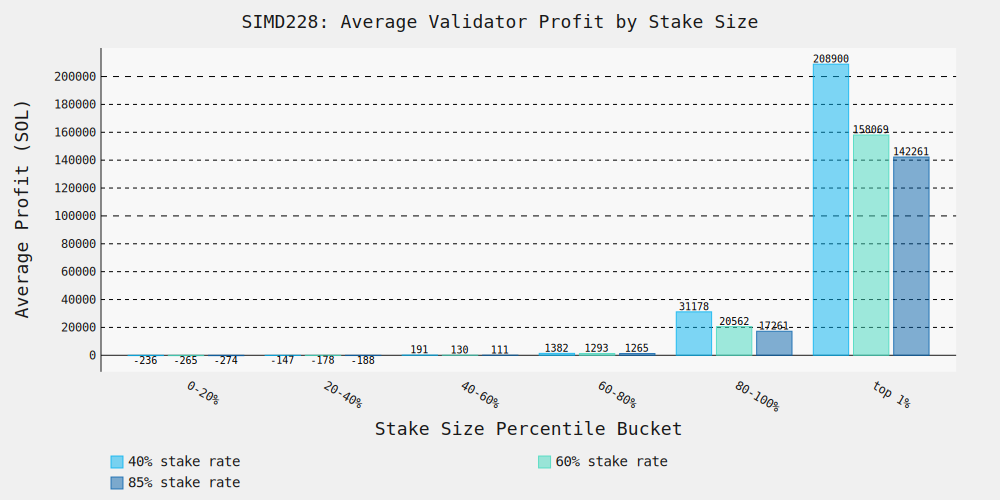

gini coefficient for low stake regime profit: 0.9248
gini coefficient for medium stake regime profit: 0.9086
gini coefficient for high stake regime profit: 0.9012
shannon entropy for low stake regime profit: 0.6556
shannon entropy for medium stake regime profit: 0.6827
shannon entropy for high stake regime profit: 0.6930


In [15]:

def bucket_profits_with_top1(df, num_buckets=5):
    # keep only relevant columns and sort by stake
    df = df[['Active Stake (SOL)', 'Profit(SOL)']].dropna().sort_values('Active Stake (SOL)').reset_index(drop=True)
    n = len(df)
    # determine the cutoff for the top 1 percentile
    top1_cutoff = int(np.ceil(n * 0.99))
    # assign all but the top 1% to quantile buckets, top 1% to a separate bucket
    bucket_labels = [f'{int(i*100/num_buckets)}-{int((i+1)*100/num_buckets)}%' for i in range(num_buckets)] + ['top 1%']
    bucket_assignment = pd.Series([None] * n)
    # assign quantile buckets to the first 99%
    if top1_cutoff > 0:
        bucket_assignment.iloc[:top1_cutoff] = pd.qcut(
            np.arange(top1_cutoff), num_buckets, labels=[f'{int(i*100/num_buckets)}-{int((i+1)*100/num_buckets)}%' for i in range(num_buckets)]
        )
    # assign 'top 1%' to the last 1%
    bucket_assignment.iloc[top1_cutoff:] = 'top 1%'
    df['bucket'] = bucket_assignment

    grouped = df.groupby('bucket', observed=True)['Profit(SOL)']
    avg_profits = grouped.mean().reindex(bucket_labels).tolist()
    total_profits = grouped.sum().reindex(bucket_labels).tolist()
    labels = bucket_labels

    return labels, avg_profits, total_profits

# compute for each scenario
labels, low_avg, low_total = bucket_profits_with_top1(low_stake, num_buckets=5)
_, med_avg, med_total = bucket_profits_with_top1(med_stake, num_buckets=5)
_, high_avg, high_total = bucket_profits_with_top1(high_stake, num_buckets=5)

from pygal.style import Style

# create a custom style with smaller value font size
custom_style = pygal.style.BlueStyle(
    value_font_size=10,
    label_font_size=12,
    major_label_font_size=12,
    legend_font_size=14,
    tooltip_font_size=12,
    title_font_size=18,
)

chart = pygal.Bar(
    title='SIMD228: Average Validator Profit by Stake Size',
    x_title='Stake Size Percentile Bucket',
    y_title='Average Profit (SOL)',
    width=1000,
    height=500,
    show_legend=True,
    legend_at_bottom=True,
    style=custom_style,
    human_readable=True,
    value_formatter=lambda x: f'{x:.0f}',
    show_y_guides=True,
    print_values=True,
    print_values_position='top',
    x_label_rotation=30,  # rotate x axis labels for readability
)

chart.x_labels = labels
chart.add('40% stake rate', [{'value': avg if avg is not np.nan else 0, 'label': f'{int(tot):,}' if tot is not np.nan else '0'} for avg, tot in zip(low_avg, low_total)])
chart.add('60% stake rate', [{'value': avg if avg is not np.nan else 0, 'label': f'{int(tot):,}' if tot is not np.nan else '0'} for avg, tot in zip(med_avg, med_total)])
chart.add('85% stake rate', [{'value': avg if avg is not np.nan else 0, 'label': f'{int(tot):,}' if tot is not np.nan else '0'} for avg, tot in zip(high_avg, high_total)])

display(SVG(chart.render()))


# calculate and print gini coefficient for each regime's profit
low_gini = calc_modified_gini(low_stake)
med_gini = calc_modified_gini(med_stake)
high_gini = calc_modified_gini(high_stake)

low_shannon = calc_shannon_entropy(low_stake)
med_shannon = calc_shannon_entropy(med_stake)
high_shannon = calc_shannon_entropy(high_stake) 

print('gini coefficient for low stake regime profit:', f'{low_gini:.4f}')
print('gini coefficient for medium stake regime profit:', f'{med_gini:.4f}')
print('gini coefficient for high stake regime profit:', f'{high_gini:.4f}')

print('shannon entropy for low stake regime profit:', f'{low_shannon:.4f}')
print('shannon entropy for medium stake regime profit:', f'{med_shannon:.4f}')
print('shannon entropy for high stake regime profit:', f'{high_shannon:.4f}')



In [16]:
s_quo_local = s_quo.copy()

low_stake = recompute_profits(apply_simd228(change_vote_fees(s_quo_local, 0.8), 0.4))
med_stake = recompute_profits(apply_simd228(change_vote_fees(s_quo_local, 0.8), 0.6))
high_stake = recompute_profits(apply_simd228(change_vote_fees(s_quo_local, 0.8), 0.85))



0.030345767344668487
0.00978250455491962
0.003387177055348868


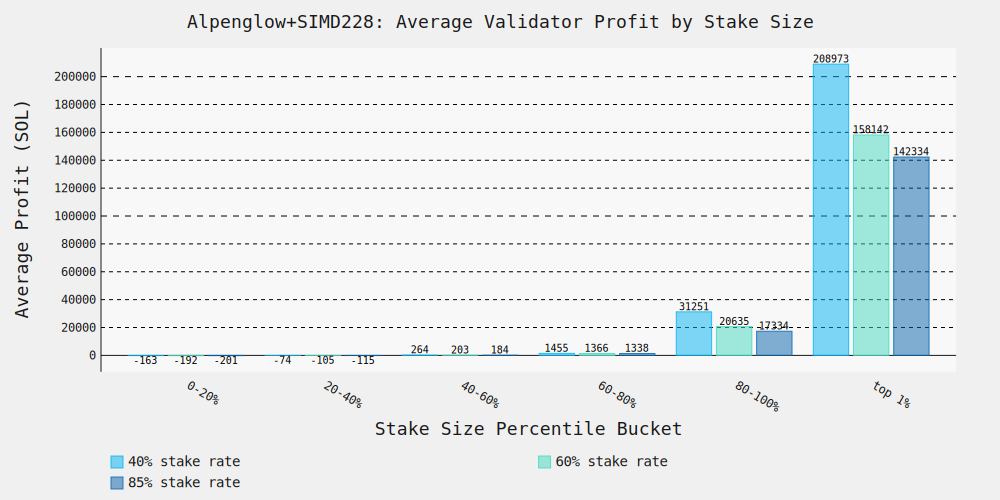

gini coefficient for alpenglow+simd228 low stake regime profit: 0.9240
gini coefficient for alpenglow+simd228 medium stake regime profit: 0.9078
gini coefficient for alpenglow+simd228 high stake regime profit: 0.9003
shannon entropy for alpenglow+simd228 low stake regime profit: 0.6583
shannon entropy for alpenglow+simd228 medium stake regime profit: 0.6860
shannon entropy for alpenglow+simd228 high stake regime profit: 0.6966


In [17]:

def bucket_profits_with_top1(df, num_buckets=5):
    # keep only relevant columns and sort by stake
    df = df[['Active Stake (SOL)', 'Profit(SOL)']].dropna().sort_values('Active Stake (SOL)').reset_index(drop=True)
    n = len(df)
    # determine the cutoff for the top 1 percentile
    top1_cutoff = int(np.ceil(n * 0.99))
    # assign all but the top 1% to quantile buckets, top 1% to a separate bucket
    bucket_labels = [f'{int(i*100/num_buckets)}-{int((i+1)*100/num_buckets)}%' for i in range(num_buckets)] + ['top 1%']
    bucket_assignment = pd.Series([None] * n)
    # assign quantile buckets to the first 99%
    if top1_cutoff > 0:
        bucket_assignment.iloc[:top1_cutoff] = pd.qcut(
            np.arange(top1_cutoff), num_buckets, labels=[f'{int(i*100/num_buckets)}-{int((i+1)*100/num_buckets)}%' for i in range(num_buckets)]
        )
    # assign 'top 1%' to the last 1%
    bucket_assignment.iloc[top1_cutoff:] = 'top 1%'
    df['bucket'] = bucket_assignment

    grouped = df.groupby('bucket', observed=True)['Profit(SOL)']
    avg_profits = grouped.mean().reindex(bucket_labels).tolist()
    total_profits = grouped.sum().reindex(bucket_labels).tolist()
    labels = bucket_labels

    return labels, avg_profits, total_profits

# compute for alpenglow+simd228 scenarios (rotor 25%)
low_labels, low_avg, low_total = bucket_profits_with_top1(low_stake, num_buckets=5)
_, med_avg, med_total = bucket_profits_with_top1(med_stake, num_buckets=5)
_, high_avg, high_total = bucket_profits_with_top1(high_stake, num_buckets=5)


# create a custom style with smaller value font size
custom_style = pygal.style.BlueStyle(
    value_font_size=10,
    label_font_size=12,
    major_label_font_size=12,
    legend_font_size=14,
    tooltip_font_size=12,
    title_font_size=18,
)

chart = pygal.Bar(
    title='Alpenglow+SIMD228: Average Validator Profit by Stake Size',
    x_title='Stake Size Percentile Bucket',
    y_title='Average Profit (SOL)',
    width=1000,
    height=500,
    show_legend=True,
    legend_at_bottom=True,
    style=custom_style,
    human_readable=True,
    value_formatter=lambda x: f'{x:.0f}',
    show_y_guides=True,
    print_values=True,
    print_values_position='top',
    x_label_rotation=30,  # rotate x axis labels for readability
)

chart.x_labels = low_labels
chart.add('40% stake rate', [{'value': avg if avg is not np.nan else 0, 'label': f'{int(tot):,}' if tot is not np.nan else '0'} for avg, tot in zip(low_avg, low_total)])
chart.add('60% stake rate', [{'value': avg if avg is not np.nan else 0, 'label': f'{int(tot):,}' if tot is not np.nan else '0'} for avg, tot in zip(med_avg, med_total)])
chart.add('85% stake rate', [{'value': avg if avg is not np.nan else 0, 'label': f'{int(tot):,}' if tot is not np.nan else '0'} for avg, tot in zip(high_avg, high_total)])

display(SVG(chart.render()))


# calculate and print gini coefficient for alpenglow+simd228 regime profits
alp_low_gini = calc_modified_gini(low_stake)
alp_med_gini = calc_modified_gini(med_stake)
alp_high_gini = calc_modified_gini(high_stake)

alp_low_shannon = calc_shannon_entropy(low_stake)
alp_med_shannon = calc_shannon_entropy(med_stake)
alp_high_shannon = calc_shannon_entropy(high_stake)

print('gini coefficient for alpenglow+simd228 low stake regime profit:', f'{alp_low_gini:.4f}')
print('gini coefficient for alpenglow+simd228 medium stake regime profit:', f'{alp_med_gini:.4f}')
print('gini coefficient for alpenglow+simd228 high stake regime profit:', f'{alp_high_gini:.4f}')

print('shannon entropy for alpenglow+simd228 low stake regime profit:', f'{alp_low_shannon:.4f}')
print('shannon entropy for alpenglow+simd228 medium stake regime profit:', f'{alp_med_shannon:.4f}')
print('shannon entropy for alpenglow+simd228 high stake regime profit:', f'{alp_high_shannon:.4f}')

## Summary: Gini Coefficients 


0.003387177055348868


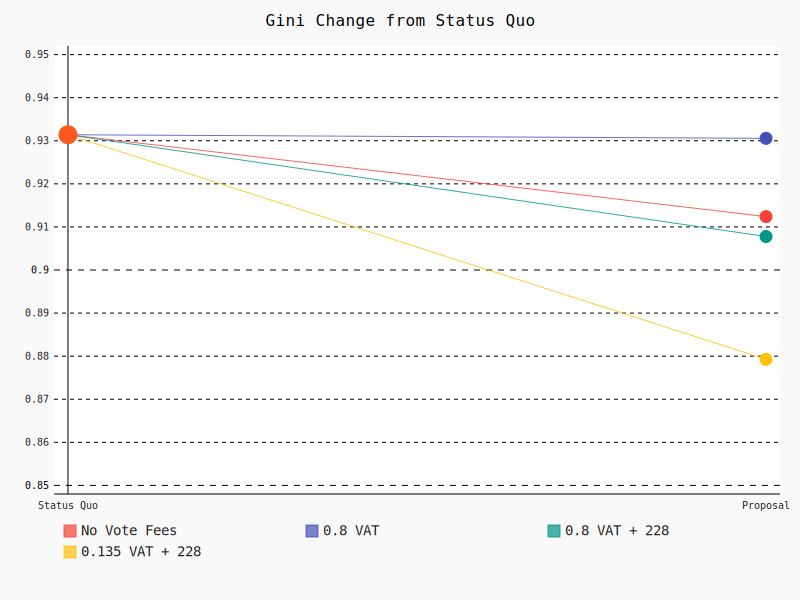

Regime      Gini
0       Status Quo  0.931398
1     No Vote Fees  0.912396
2          0.8 VAT  0.930565
3    0.8 VAT + 228  0.907769
4  0.135 VAT + 228  0.879256

In [18]:


import pygal
from IPython.display import SVG, display

# get baseline (status quo) dataframe
try:
    base_df = s_quo.copy()
except NameError:
    try:
        base_df = load_and_clean_data('../data/validator_profit.csv')
    except Exception as e:
        raise RuntimeError("could not locate baseline dataframe 's_quo' or load data.") from e

def _ensure_profit(df):
    # ensure profit(sol) exists and is consistent with your utils
    if 'Profit(SOL)' not in df.columns:
        df2 = recompute_profits(df)
        return df2
    return df

# build each regime deterministically
reg_status_quo = _ensure_profit(base_df)

try:
    reg_no_vote = alpenglow_no_vote.copy()
    reg_no_vote = _ensure_profit(reg_no_vote)
except NameError:
    reg_no_vote = _ensure_profit(recompute_profits(change_vote_fees(base_df.copy(), 0)))

reg_80 = _ensure_profit(recompute_profits(change_vote_fees(base_df.copy(), 0.8)))

stake_ratio_default = 0.85
try:
    reg_80_simd228 = _ensure_profit(med_stake.copy())
except NameError:
    reg_80_simd228 = _ensure_profit(recompute_profits(apply_simd228(change_vote_fees(base_df.copy(), 0.8), stake_ratio_default)))

try:
    reg_0135_simd228 = _ensure_profit(med_stake.copy())
    reg_0135_simd228 = _ensure_profit(recompute_profits(apply_simd228(change_vote_fees(base_df.copy(), 0.135), stake_ratio_default)))
except NameError:
    reg_0135_simd228 = _ensure_profit(recompute_profits(apply_simd228(change_vote_fees(base_df.copy(), 0.135), stake_ratio_default)))

def _g(df):
    return float(calc_modified_gini(df))

labels = [
    "Status Quo",
    "No Vote Fees",
    "0.8 VAT",
    "0.8 VAT + 228",
    "0.135 VAT + 228"
]

values = [
    _g(reg_status_quo),
    _g(reg_no_vote),
    _g(reg_80),
    _g(reg_80_simd228),
    _g(reg_0135_simd228)
]

# render pygal bar chart with y-axis zoomed to [0.8, 1]
# bar = pygal.Line(
#     x_label_rotation=20,
#     show_legend=False,
#     title="Validator Profitability Gini Coefficient Across Regimes",
#     range=(0.85, 0.95),
#     print_values=True,
#     value_formatter=lambda x: f'{x:.4f}',
# )
# bar.x_labels = labels
# bar.add("Gini", values)
# display(SVG(bar.render()))

x_axis = ["Status Quo", "Proposal"]
cfg = pygal.Config()
cfg.show_legend = True
cfg.legend_at_bottom = True
cfg.dots_size = 6
cfg.range = (0.85, 0.95)
cfg.strict = True
slope = pygal.Line(cfg, title="Gini Change from Status Quo")
slope.x_labels = x_axis
cfg.legend_box_size = 10

# draw the proposals first (your existing code)
for lab, val in zip(labels[1:], values[1:]):
    slope.add(lab, [values[0], val])  # each regime is a 2-point line

# overlay the baseline dot LAST so it sits on top
slope.add(
    None,             # you can use "" if you don't want it in the legend
    [values[0], None],         # left dot only
    color="#000000",           # black
    dots_size=9,               # a touch bigger for emphasis
    stroke_style={"width": 0}  # no line from it
)
display(SVG(slope.render()))
try:
    import pandas as pd
    display(pd.DataFrame({"Regime": labels, "Gini": values}))
except Exception:
    pass
